# Berechnung Heizlast

## 1. Bibliotheken importieren

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## 2. Gewächshaus-Parameter

In [2]:
A_grund = 10000                 # Grundfläche in m²
hoehe = 4.5                     # Höhe in m
V = A_grund * hoehe             # Luftvolumen in m³ (= 4500 m³)

# Hüllfläche berechnen (Dach + 4 Wände, quadratisch angenommen)
seite = math.sqrt(A_grund)      # Seitenlänge ≈ 31.6 m
A_wand = 4 * seite * hoehe      # Wandfläche
A_dach = A_grund                # Dachfläche ≈ Grundfläche
A_huell = A_wand + A_dach       # Gesamte Hüllfläche ≈ 1569 m²

print(f"Grundfläche: {A_grund} m²")
print(f"Volumen: {V} m³")
print(f"Hüllfläche: {A_huell:.0f} m² (Dach: {A_dach:.0f} + Wände: {A_wand:.0f})")

Grundfläche: 10000 m²
Volumen: 45000.0 m³
Hüllfläche: 11800 m² (Dach: 10000 + Wände: 1800)


## 3. Thermische Parameter

In [4]:
U = 4.0                         # U-Wert in W/(m²·K) - typisch Gewächshaus
T_i = 20                        # Solltemperatur Gewächshaus in °C
n = 0.5                         # LuftwechselratUe in 1/h
cp_luft = 0.33333               # Spez. Wärmekapazität Luft in Wh/(K·m³)
eta_solar = 0.8                 # Solarer Transmissionsgrad (0.75-0.9)

## 4. Außentemperaturdaten Köln einlesen – nur 2019

In [3]:
df_temp = pd.read_csv('Temperatur Köln.csv', sep=';')
df_temp['MESS_DATUM'] = df_temp['MESS_DATUM'].astype(str)
df_temp = df_temp[df_temp['MESS_DATUM'].str.startswith('2019')]
df_temp = df_temp.reset_index(drop=True)

T_a = df_temp['TT_TU'].values   # Außentemperatur in °C

print(f"Temperaturdaten 2019: {len(T_a)} Stunden")

Temperaturdaten 2019: 8760 Stunden


## 5. Solardaten Bochum/Bremen einlesen – nur 2019

In [6]:
df_solar = pd.read_csv('Solareinstrahlung_Bochum_Bremen.csv', sep=';')
df_solar.columns = df_solar.columns.str.strip()
df_solar['DateTime'] = df_solar['DateTime'].astype(str)
df_solar = df_solar[df_solar['DateTime'].str.startswith('2019')]
df_solar = df_solar.reset_index(drop=True)

# Globalstrahlung in W/m²
G_solar = df_solar['Solar_W_m2'].values.astype(float)

print(f"Solardaten 2019: {len(G_solar)} Stunden")

Solardaten 2019: 8760 Stunden


## 6. Stündliche Heizlastberechnung

In [8]:
Q_dot = []

for t in range(n_hours):
    
    # Transmissionswärmeverlust: Q = U × A × ΔT
    Q_trans = U * A_huell * (T_i - T_a[t])      # in W

    # Lüftungswärmeverlust: Q = V × n × cp × ΔT
    Q_luft = V * n * cp_luft * (T_i - T_a[t])  # in W

    # Solare Gewinne durch Dachfläche
    Q_solar = G_solar[t] * A_dach * eta_solar  # in W

    # Netto-Heizlast in kW
    Q = (Q_trans + Q_luft - Q_solar) / 1000
    Q_dot.append(max(Q, 0))  # keine negativen Werte (= keine Kühlung)

Q_dot = np.array(Q_dot)

# Ergebnisse ausgeben
print(f"--- Ergebnisse Heizlast 2019 ---")
print(f"Maximale Heizlast: {Q_dot.max():.1f} kW")
print(f"Mittlere Heizlast: {Q_dot.mean():.1f} kW")
print(f"Gesamter Heizenergiebedarf: {Q_dot.sum():.0f} kWh/a")
print(f"Stunden ohne Heizbedarf: {(Q_dot == 0).sum()}")

--- Ergebnisse Heizlast 2019 ---
Maximale Heizlast: 1597.2 kW
Mittlere Heizlast: 344.8 kW
Gesamter Heizenergiebedarf: 3020283 kWh/a
Stunden ohne Heizbedarf: 3713


## 7. CSV exportieren

In [9]:
df_result = pd.DataFrame({
    'MESS_DATUM': df_temp['MESS_DATUM'].values[:n_hours],
    'T_aussen_C': T_a,
    'Heizlast_kW': Q_dot
})
df_result.to_csv('heizlast_2019.csv', index=False)
print(f"Exportiert nach: heizlast_2019.csv")

Exportiert nach: heizlast_2019.csv


## 8. Graph erstellen

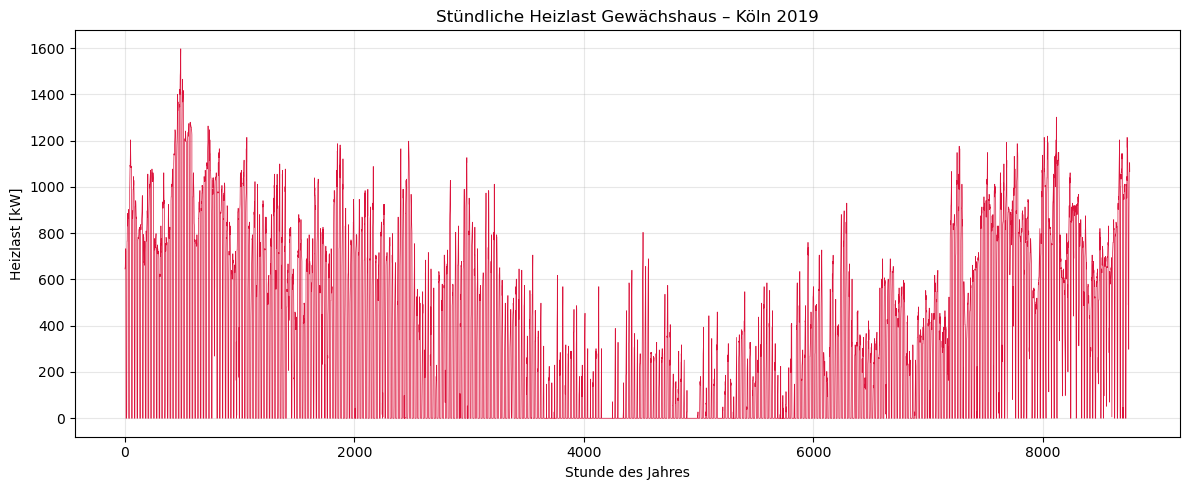

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(Q_dot, linewidth=0.5, color='crimson')
plt.xlabel("Stunde des Jahres")
plt.ylabel("Heizlast [kW]")
plt.title("Stündliche Heizlast Gewächshaus – Köln 2019")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()